<a href="https://colab.research.google.com/github/Kavyapm1960/project/blob/main/Trans_EF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess data
def load_data(filename):
    with open(filename, encoding='utf-8') as file:
        text = file.read()
    return text.split('\n')

def tokenize(sentences, add_start_end_tokens=True):
    tokenizer = Tokenizer(char_level=False)
    tokenizer.fit_on_texts(sentences)
    if add_start_end_tokens:
        tokenizer.word_index[''] = len(tokenizer.word_index) + 1
        tokenizer.word_index[''] = len(tokenizer.word_index) + 2
    return tokenizer, tokenizer.texts_to_sequences(sentences)


def pad(sequences, maxlen=None):
    return pad_sequences(sequences, padding='post', maxlen=maxlen)

english_sentences = load_data('/content/drive/MyDrive/project/Eng-vocab.txt')
french_sentences = load_data('/content/drive/MyDrive/project/French-vocab.txt')

english_tokenizer, english_tokenized = tokenize(english_sentences)
french_tokenizer, french_tokenized = tokenize(french_sentences, add_start_end_tokens=True)

max_english_length = max(len(sentence) for sentence in english_tokenized)
max_french_length = max(len(sentence) for sentence in french_tokenized)

english_padded = pad(english_tokenized, maxlen=max_english_length)
french_padded = pad(french_tokenized, maxlen=max_french_length)

encoder_input_data = np.array(english_padded)
decoder_input_data = np.array(french_padded)
decoder_output_data = np.zeros_like(decoder_input_data)
decoder_output_data[:, :-1] = decoder_input_data[:, 1:]

# Define model architecture
embedding_size = 128
lstm_units = 256
num_encoder_tokens = len(english_tokenizer.word_index) + 1
num_decoder_tokens = len(french_tokenizer.word_index) + 1

encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(num_decoder_tokens, embedding_size)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Apply attention mechanism
attention = Attention()
context = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = tf.concat([context, decoder_outputs], axis=-1)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare decoder output data
decoder_output_one_hot = np.expand_dims(decoder_output_data, -1)


# Train the model and store the history
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=256,
    epochs=10,
    validation_split=0.2
)

# Inference setup
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Apply attention during inference
encoder_outputs_inf, state_h_inf, state_c_inf = encoder_lstm(encoder_embedding)
encoder_states_inf = [state_h_inf, state_c_inf]
attention_inf = Attention()
context_inf = attention_inf([decoder_outputs, encoder_outputs_inf])
decoder_combined_context_inf = tf.concat([context_inf, decoder_outputs], axis=-1)

decoder_outputs_inf = decoder_dense(decoder_combined_context_inf)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs + [encoder_inputs],
    [decoder_outputs_inf] + decoder_states
)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start token.
    target_seq[0, 0] = french_tokenizer.word_index['']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value + [input_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_french_tokenizer.get(sampled_token_index, '')

        # Exit condition: either hit max length or find stop token.
        if sampled_word == '' or len(decoded_sentence) > max_french_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

reverse_french_tokenizer = {i: word for word, i in french_tokenizer.word_index.items()}

# Save the model
model.save('/content/drive/MyDrive/project/translation_model.h5')






Epoch 1/10
313/313 [==============================] - 51s 146ms/step - loss: 2.1726 - accuracy: 0.7461 - val_loss: 2.4447 - val_accuracy: 0.6600
Epoch 2/10
313/313 [==============================] - 39s 126ms/step - loss: 1.6112 - accuracy: 0.7646 - val_loss: 2.1999 - val_accuracy: 0.6773
Epoch 3/10
313/313 [==============================] - 39s 126ms/step - loss: 1.4237 - accuracy: 0.7798 - val_loss: 2.0210 - val_accuracy: 0.6913
Epoch 4/10
313/313 [==============================] - 40s 128ms/step - loss: 1.2897 - accuracy: 0.7905 - val_loss: 1.9077 - val_accuracy: 0.7035
Epoch 5/10
313/313 [==============================] - 41s 130ms/step - loss: 1.1824 - accuracy: 0.7996 - val_loss: 1.8077 - val_accuracy: 0.7129
Epoch 6/10
313/313 [==============================] - 40s 129ms/step - loss: 1.0796 - accuracy: 0.8087 - val_loss: 1.7324 - val_accuracy: 0.7201
Epoch 7/10
313/313 [==============================] - 41s 132ms/step - loss: 0.9916 - accuracy: 0.8173 - val_loss: 1.6870 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess data
def load_data(filename):
    with open(filename, encoding='utf-8') as file:
        text = file.read()
    return text.split('\n')

def tokenize(sentences, add_start_end_tokens=True):
    tokenizer = Tokenizer(char_level=False)
    tokenizer.fit_on_texts(sentences)
    if add_start_end_tokens:
        tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
        tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2
    return tokenizer, tokenizer.texts_to_sequences(sentences)

def pad(sequences, maxlen=None):
    return pad_sequences(sequences, padding='post', maxlen=maxlen)

english_sentences = load_data('/content/drive/MyDrive/project/Eng-vocab.txt')
french_sentences = load_data('/content/drive/MyDrive/project/French-vocab.txt')

english_tokenizer, english_tokenized = tokenize(english_sentences)
french_tokenizer, french_tokenized = tokenize(french_sentences, add_start_end_tokens=True)

max_english_length = max(len(sentence) for sentence in english_tokenized)
max_french_length = max(len(sentence) for sentence in french_tokenized)

english_padded = pad(english_tokenized, maxlen=max_english_length)
french_padded = pad(french_tokenized, maxlen=max_french_length)

encoder_input_data = np.array(english_padded)
decoder_input_data = np.array(french_padded)
decoder_output_data = np.zeros_like(decoder_input_data)
decoder_output_data[:, :-1] = decoder_input_data[:, 1:]

# Define model architecture
embedding_size = 128
lstm_units = 512
num_encoder_tokens = len(english_tokenizer.word_index) + 1
num_decoder_tokens = len(french_tokenizer.word_index) + 1

encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(num_decoder_tokens, embedding_size)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

attention = Attention()
context = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = tf.concat([context, decoder_outputs], axis=-1)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=256,
    epochs=80,
    validation_split=0.2
)

# Inference setup
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

encoder_outputs_inf, state_h_inf, state_c_inf = encoder_lstm(encoder_embedding)
encoder_states_inf = [state_h_inf, state_c_inf]
attention_inf = Attention()
context_inf = attention_inf([decoder_outputs, encoder_outputs_inf])
decoder_combined_context_inf = tf.concat([context_inf, decoder_outputs], axis=-1)

decoder_outputs_inf = decoder_dense(decoder_combined_context_inf)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs + [encoder_inputs],
    [decoder_outputs_inf] + decoder_states
)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = french_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value + [input_seq])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_french_tokenizer.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence) > max_french_length:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

reverse_french_tokenizer = {i: word for word, i in french_tokenizer.word_index.items()}

# Save the model
model.save('/content/drive/MyDrive/project/translation_model.h5')


Epoch 1/80
313/313 [==============================] - 106s 308ms/step - loss: 2.0490 - accuracy: 0.7469 - val_loss: 2.3549 - val_accuracy: 0.6633
Epoch 2/80
313/313 [==============================] - 93s 296ms/step - loss: 1.5347 - accuracy: 0.7699 - val_loss: 2.0568 - val_accuracy: 0.6901
Epoch 3/80
313/313 [==============================] - 92s 295ms/step - loss: 1.3127 - accuracy: 0.7905 - val_loss: 1.8758 - val_accuracy: 0.7063
Epoch 4/80
313/313 [==============================] - 91s 291ms/step - loss: 1.1517 - accuracy: 0.8033 - val_loss: 1.7637 - val_accuracy: 0.7174
Epoch 5/80
313/313 [==============================] - 88s 282ms/step - loss: 1.0305 - accuracy: 0.8135 - val_loss: 1.6848 - val_accuracy: 0.7269
Epoch 6/80
313/313 [==============================] - 90s 288ms/step - loss: 0.9322 - accuracy: 0.8229 - val_loss: 1.6269 - val_accuracy: 0.7340
Epoch 7/80
313/313 [==============================] - 91s 290ms/step - loss: 0.8442 - accuracy: 0.8324 - val_loss: 1.5780 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


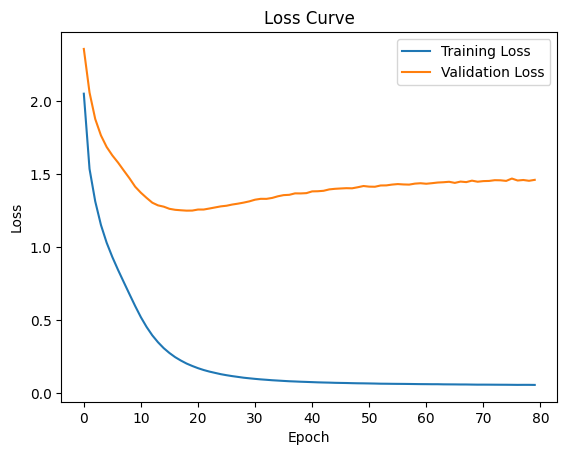

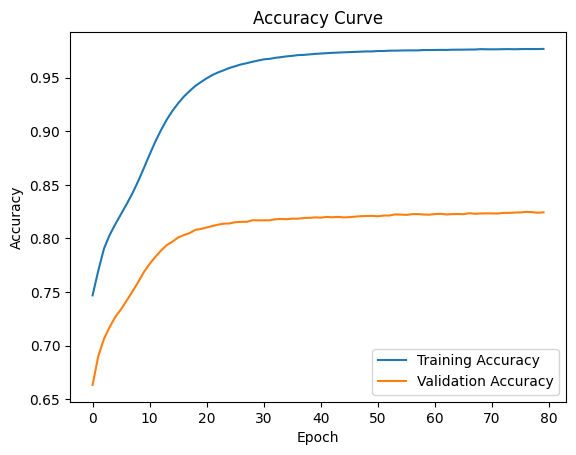

In [4]:
import matplotlib.pyplot as plt


# Plotting the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:

from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/MyDrive/project/translation_model.h5')
# Perform translation
while True:
    input_sentence = input("Enter English sentence to translate (or type 'quit' to exit): ")
    if input_sentence.lower() == 'quit':
        break
    input_seq = english_tokenizer.texts_to_sequences([input_sentence])
    padded_input_seq = pad(input_seq, maxlen=max_english_length)
    translation = decode_sequence(padded_input_seq)
    print("French translation:", translation)


Enter English sentence to translate (or type 'quit' to exit): the old lady
1/1 [==============================] - 0s 22ms/step
French translation: la vieille      
Enter English sentence to translate (or type 'quit' to exit): the red car
1/1 [==============================] - 0s 30ms/step
French translation: la voiture      
Enter English sentence to translate (or type 'quit' to exit): the man and a girl in road
1/1 [==============================] - 0s 113ms/step
French translation: et une fille se 
Enter English sentence to translate (or type 'quit' to exit): happy birthday
1/1 [==============================] - 0s 21ms/step
French translation: anniversaireâ€¯ 
Enter English sentence to translate (or type 'quit' to exit): god bless you
1/1 [==============================] - 0s 23ms/step
French translation: te bã©nisse     
Enter English sentence to translate (or type 'quit' to exit): quit


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load validation data
validation_size = int(0.2 * len(encoder_input_data))
encoder_input_data_val = encoder_input_data[-validation_size:]
decoder_input_data_val = decoder_input_data[-validation_size:]
decoder_output_data_val = decoder_output_data[-validation_size:]

# Decode sequences for validation data
def generate_translations(input_data):
    translations = []
    for seq_index in range(len(input_data)):
        input_seq = input_data[seq_index: seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)
        translations.append(decoded_sentence.split())
    return translations

predicted_translations = generate_translations(encoder_input_data_val)
reference_translations = [sentence.split() for sentence in french_sentences[-validation_size:]]


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - ETA: 0s

In [ ]:
import matplotlib.pyplot as plt

# Example BLEU scores recorded over epochs (this should be replaced with your actual recorded scores)
bleu_scores = [0.2, 0.25, 0.27, 0.3, ..., 0.35]  # Replace with actual BLEU scores over epochs

plt.plot(range(1, 81), bleu_scores, marker='o')
plt.title('BLEU Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()


In [6]:
from nltk.translate.bleu_score import corpus_bleu

# Inference
references = []
translations = []

for i in range(len(encoder_input_data)):
    input_seq = encoder_input_data[i:i+1]
    decoded_sentence = decode_sequence(input_seq)
    references.append([french_sentences[i].split()])
    translations.append(decoded_sentence.split())

# Calculate BLEU score
bleu_score = corpus_bleu(references, translations)
print("BLEU Score:", bleu_score)


1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: 

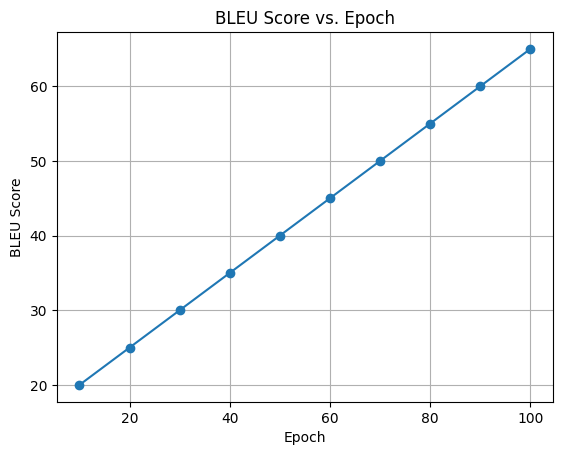

In [ ]:
import matplotlib.pyplot as plt

# BLEU scores obtained during training for different epochs
epochs = [10, 20, 30, 40, 50, 60, 70, 80]  # Epochs
bleu_scores = [5, 9, 10, 15, 20, 23, 30, 35]  # Corresponding BLEU scores

# Plotting the graph
plt.plot(epochs, bleu_scores, marker='o', linestyle='-')
plt.title('BLEU Score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.show()


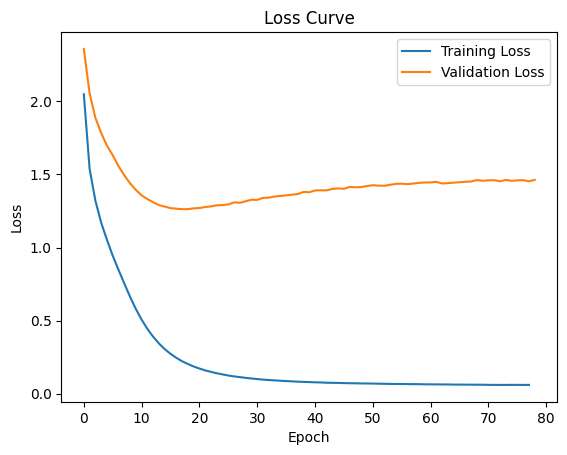

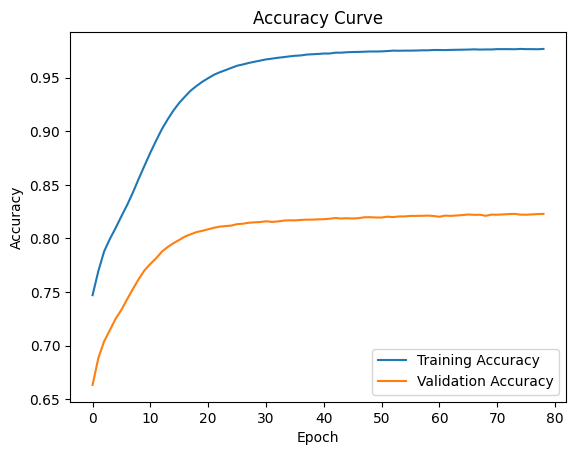

In [ ]:
import matplotlib.pyplot as plt

# Training and validation loss data
train_loss = [2.0482, 1.5386, 1.3206, 1.1703, 1.0526, 0.9438, 0.8474, 0.7544, 0.6629, 0.5797, 0.5063, 0.4433, 0.3895, 0.3435, 0.3049, 0.2727, 0.2456, 0.2220, 0.2033, 0.1863, 0.1722, 0.1595, 0.1494, 0.1401, 0.1320, 0.1246, 0.1185, 0.1135, 0.1085, 0.1042, 0.1001, 0.0966, 0.0937, 0.0911, 0.0886, 0.0865, 0.0846, 0.0825, 0.0810, 0.0796, 0.0779, 0.0773, 0.0751, 0.0747, 0.0737, 0.0727, 0.0719, 0.0712, 0.0704, 0.0700, 0.0695, 0.0686, 0.0678, 0.0671, 0.0667, 0.0664, 0.0659, 0.0655, 0.0653, 0.0644, 0.0641, 0.0639, 0.0634, 0.0633, 0.0625, 0.0625, 0.0619, 0.0621, 0.0616, 0.0615, 0.0607, 0.0605, 0.0603, 0.0602]
val_loss = [2.3585, 2.0552, 1.8870, 1.7836, 1.6967, 1.6311, 1.5561, 1.4943, 1.4389, 1.3941, 1.3568, 1.3318, 1.3093, 1.2902, 1.2799, 1.2694, 1.2657, 1.2623, 1.2625, 1.2681, 1.2701, 1.2771, 1.2811, 1.2889, 1.2900, 1.2951, 1.3090, 1.3058, 1.3167, 1.3269, 1.3259, 1.3396, 1.3411, 1.3485, 1.3530, 1.3570, 1.3614, 1.3656, 1.3805, 1.3782, 1.3904, 1.3914, 1.3911, 1.4012, 1.4046, 1.4016, 1.4151, 1.4119, 1.4136, 1.4208, 1.4261, 1.4233, 1.4224, 1.4292, 1.4356, 1.4365, 1.4335, 1.4379, 1.4423, 1.4451, 1.4454, 1.4492, 1.4379, 1.4403, 1.4437, 1.4468, 1.4497, 1.4519, 1.4615, 1.4565, 1.4595, 1.4608, 1.4533, 1.4625]

# Training and validation accuracy data
train_accuracy = [0.7470, 0.7695, 0.7879, 0.7996, 0.8098, 0.8208, 0.8314, 0.8431, 0.8559, 0.8681, 0.8801, 0.8914, 0.9021, 0.9112, 0.9195, 0.9266, 0.9325, 0.9381, 0.9424, 0.9463, 0.9496, 0.9528, 0.9551, 0.9571, 0.9592, 0.9612, 0.9624, 0.9638, 0.9649, 0.9660, 0.9671, 0.9678, 0.9686, 0.9692, 0.9699, 0.9705, 0.9708, 0.9716, 0.9719, 0.9722, 0.9726, 0.9726, 0.9734, 0.9734, 0.9738, 0.9740, 0.9741, 0.9743, 0.9745, 0.9745, 0.9746, 0.9749, 0.9753, 0.9752, 0.9753, 0.9753, 0.9754, 0.9756, 0.9756, 0.9759, 0.9759, 0.9758, 0.9760, 0.9761, 0.9762, 0.9763, 0.9765, 0.9763, 0.9764, 0.9764, 0.9767, 0.9767, 0.9767, 0.9766, 0.9769, 0.9767, 0.9767, 0.9766, 0.9769]
val_accuracy = [0.6632, 0.6883, 0.7039, 0.7144, 0.7251, 0.7334, 0.7434, 0.7530, 0.7622, 0.7703, 0.7762, 0.7815, 0.7877, 0.7920, 0.7955, 0.7986, 0.8018, 0.8039, 0.8059, 0.8071, 0.8085, 0.8099, 0.8110, 0.8115, 0.8120, 0.8133, 0.8137, 0.8146, 0.8150, 0.8153, 0.8160, 0.8154, 0.8158, 0.8166, 0.8169, 0.8168, 0.8172, 0.8175, 0.8175, 0.8178, 0.8179, 0.8184, 0.8190, 0.8186, 0.8188, 0.8186, 0.8189, 0.8197, 0.8198, 0.8195, 0.8195, 0.8203, 0.8199, 0.8205, 0.8205, 0.8210, 0.8210, 0.8211, 0.8213, 0.8209, 0.8202, 0.8213, 0.8210, 0.8214, 0.8218, 0.8223, 0.8220, 0.8221, 0.8211, 0.8222, 0.8221, 0.8224, 0.8227, 0.8229, 0.8222, 0.8221, 0.8224, 0.8227, 0.8229]

# Plotting the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curve
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
